In [1]:
using Dates
a = now()
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, Optim
using DiffEqFlux, Flux
using Random
using CSV
using Lux
using DataFrames
using JLD
using Plots
gr()
println(a - now())

┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq /Users/adrocampos/.julia/packages/DataDrivenDiffEq/fivVr/src/DataDrivenDiffEq.jl:168


-129411 milliseconds


## Loading the data

In [2]:
data_dir = "/Users/adrocampos/covid19/synth_data/"
regions = ["2", "3", "5", "10", "15", "20", "30"][1]
mobility_type = ["inv_dist", "border", "neighbor"][2]
initially_recovered = false


file = "1"

csv_reader = CSV.File(data_dir * "SIR_" * regions * "_regions_" * mobility_type * "_" * file * ".csv")
df = DataFrame(csv_reader)

index = range(1, stop=5001, step=200)
df = df[index, :]

X = Matrix(df[:, [:S1, :I1, :R1]])
X = transpose(X)
println("size(X) =", size(X))

tspan = (1, size(X)[2])
t = range(tspan[1], tspan[2], step=1)
u0 = X[:, 1]


size(X) =(3, 26)


3-element Vector{Float64}:
 2773.0
    7.0
    0.0

In [3]:
neighbor = 2

2

In [4]:
distance = CSV.File(data_dir * "distances_" * regions * "_regions.csv")
distance = DataFrame(distance)
distance = distance[1,:][neighbor + 1]

9.90074803798193

In [5]:
mobility = CSV.File(data_dir * "mobility_" * regions * "_regions_" * mobility_type * ".csv")
mobility = DataFrame(mobility)
mobility = mobility[1,:][neighbor + 1]

0.012352992645740076

In [6]:
border_lenght = CSV.File(data_dir * "border_lengths_" * regions * "_regions.csv")
border_lenght = DataFrame(border_lenght)
border_lenght = border_lenght[1,:][neighbor + 1]

4.0009760844839475

In [7]:
X_n = Matrix(df[:, [:S2, :I2, :R2]])
u0_n = transpose(X_n)[:, 1]

3-element Vector{Float64}:
 1078.0
    3.0
    0.0

In [ ]:
# plt3d = Plots.plot(X2[1,:],X2[3,:], X2[2,:], seriestype=:scatter, markersize = 3)
# display(plt3d)

In [ ]:
# rng = Random.default_rng()
# ann = Lux.Chain(Lux.Dense(3, 64, NNlib.tanh), 
#                 Lux.Dense(64, 64, NNlib.tanh), 
#                 Lux.Dense(64, 1))

# # Initialize the model weights and state
# p, st = Lux.setup(rng, ann)


In [14]:
ann = FastChain(
    FastDense(9,16,tanh), FastDense(16,16,tanh), FastDense(16, 2)
)

p = [rand(Float32, 2); Float64.(initial_params(ann))]


# function dudt!(du, u, p, t)
    
#     N = sum(u[1:3])
#     S1, I1, R1 = u[1:3]
#     β = .1
#     γ = 1/10
    
#     S2, I2, R2 = u[4:6]
    
#     z  = ann([S2, I2, R2], p)
#     du[1] = dS = -β* S1 * I1/N - z[1]
#     du[2] = dI = β* S1 * I1/N + z[2] - γ*I1
#     du[3] = dR = γ * I1

# end

function dudt!(du, u, p, t)
    
    N = sum(u[1:3])
#     β = .1
#     γ = 1/10
    
    β = p[1]
    γ = p[2]
    
    S, I, R = u[1:3]
    
    
    z  = ann([u; u0_n; [distance, mobility, border_lenght]], p[3:end])
    du[1] = dS = -β* S * I/N - z[1]
    du[2] = dI = β* S * I/N + z[2] - γ*I
    du[3] = dR = γ * I

end


## Prediction with initial random weights
prob_UODE = ODEProblem(dudt!, u0, tspan, p) ##prob_neuralode

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /Users/adrocampos/.julia/packages/DiffEqFlux/Em1Aj/src/fast_layers.jl:9


ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (1, 26)
u0: 3-element Vector{Float64}:
 2773.0
    7.0
    0.0

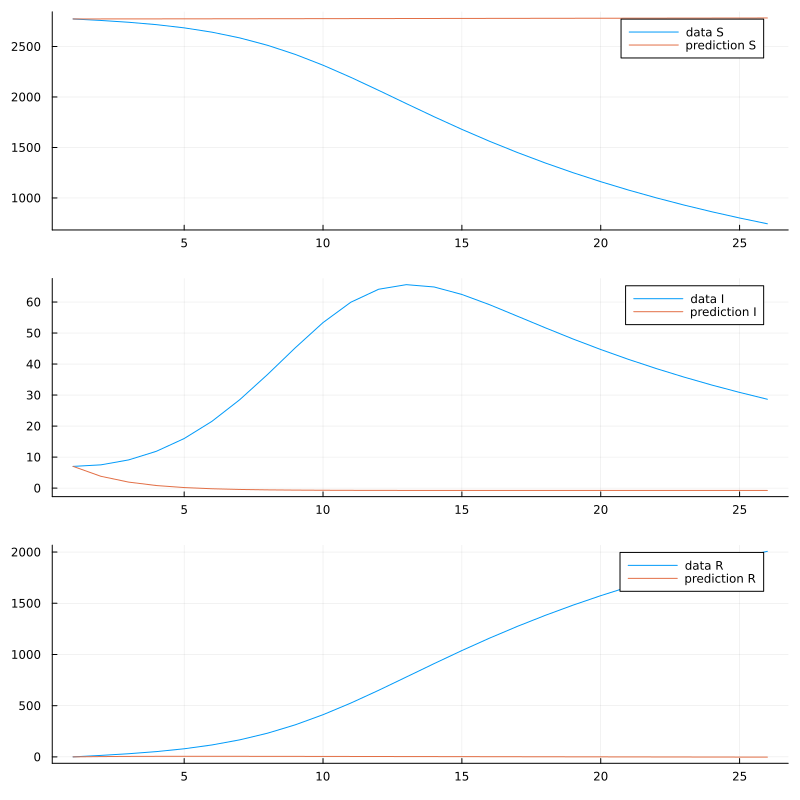

In [15]:
## Function to train the network
# Define a predictor
function predict(θ)
    Array(concrete_solve(prob_UODE, Vern7(), u0=u0, p=θ,
    tspan=tspan, saveat=1, abstol=1e-6, reltol=1e-6,
    sensealg=ForwardDiffSensitivity()
    ))
end
a = predict(p)

pS = plot(t, [X[1,:], a[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], a[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], a[3,:]], label=["data R" "prediction R"])

display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))

In [16]:
## .- instead of -?
function loss(θ)
    X̂ = predict(θ)
    sum(abs2, X .- X̂) / size(X, 2) + convert(eltype(θ), 1e-3) * sum(abs2, θ) ./ length(θ)
end
loss(p)

2.6661709158079154e6

In [17]:
losses = Float32[] 
callback(θ, l) = begin
    l = loss(θ) 
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    false
end

callback (generic function with 1 method)

### Option 1: optimize with sciml

In [ ]:
@time res1_uode = DiffEqFlux.sciml_train(loss, p, ADAM(0.1), cb=callback,  maxiters=500)
save("res1_uode.jld", "data", res1_uode)

In [ ]:
preds = predict(res1_uode)
pS = plot(t, [X[1,:], preds[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], preds[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], preds[3,:]], label=["data R" "prediction R"])
display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))

In [ ]:
res2_uode = DiffEqFlux.sciml_train(loss, res1_uode.minimizer, BFGS(initial_stepnorm=0.1), cb=callback, maxiters = 200)

### Option 2: optimize with Optimization.jl

In [18]:
pinit = Lux.ComponentArray(p)
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

OptimizationProblem. In-place: true
u0: 468-element Vector{Float64}:
  0.03619426488876343
  0.5654327273368835
  0.18802505731582642
  0.019848188385367393
 -0.10529635846614838
  0.1371443122625351
  0.38742733001708984
  0.42234277725219727
 -0.04701995849609375
 -0.10721037536859512
  0.4602946639060974
 -0.13618619740009308
  0.4646036922931671
  ⋮
  0.18721263110637665
 -0.5360046625137329
 -0.2112959772348404
  0.02336922101676464
  0.15550044178962708
  0.3853119909763336
  0.33769047260284424
 -0.37859028577804565
 -0.41665396094322205
 -0.14997905492782593
  0.0
  0.0

In [ ]:
# ## Gives the parameters back!
# @time res1_uode = Optimization.solve(optprob, Adam(0.01,(0.8,0.8)), callback=callback, maxiters=300)

In [20]:
## Gives the parameters back!
@time res1_uode = Optimization.solve(optprob, Adam(0.1,(0.9, 0.8)), callback=callback, maxiters=500)
save("res1_uode.jld", "data", res1_uode)

Current loss after 50 iterations: 119284.16
Current loss after 100 iterations: 37503.43
Current loss after 150 iterations: 26032.416
Current loss after 200 iterations: 25608.074
Current loss after 250 iterations: 25046.965
Current loss after 300 iterations: 32682.592
Current loss after 350 iterations: 11135.025
Current loss after 400 iterations: 9265.37
Current loss after 450 iterations: 7108.6333
Current loss after 500 iterations: 6988.824
1203.550215 seconds (563.44 M allocations: 2.184 TiB, 31.54% gc time, 0.84% compilation time)


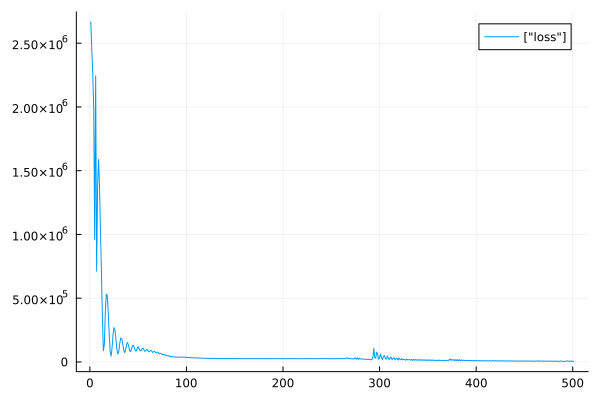

In [21]:
pL = plot(losses, label=["loss"])
display(plot(pL))

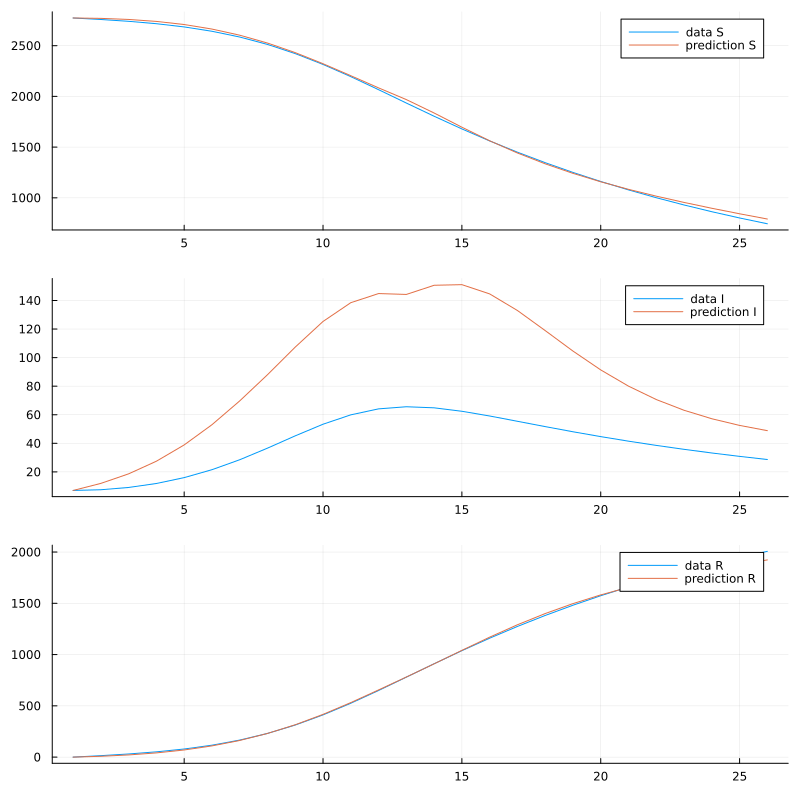

In [22]:
preds = predict(res1_uode)
pS = plot(t, [X[1,:], preds[1,:]], label=["data S" "prediction S"])
pI = plot(t, [X[2,:], preds[2,:]], label=["data I" "prediction I"])
pR = plot(t, [X[3,:], preds[3,:]], label=["data R" "prediction R"])
display(plot(pS, pI, pR, layout = (3,1), size = (800, 800)))


In [ ]:
result_neuralode.minimizer

In [ ]:
p = res1_uode.minimizer

losses2 = Float32[] 
callback(θ, args...) = begin
    l = loss(θ) # Equivalent L2 loss
    push!(losses2, l)
    if length(losses2) % 50 == 0
        println("Current loss after $(length(losses2)) iterations: $(losses2[end])")
    end
    false
end


pinit = Lux.ComponentArray(p)
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

## Gives the parameters back!
result_neuralode = Optimization.solve(optprob, BFGS(initial_stepnorm=0.01), callback=callback, maxiters=500)

## Using SINDy to discover missing term

In [23]:
size(X)

(3, 26)

In [77]:
u0_n

3-element Vector{Float64}:
 1078.0
    3.0
    0.0

In [87]:
u0_na = repeat([u0_n],size(X)[2])

78-element Vector{Float64}:
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0
 1078.0
    ⋮
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0
 1078.0
    3.0
    0.0

In [97]:
# specified number of times.
B = [1, 2, 3, 4]
println(repeat(B, outer=4))

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]


In [94]:

infos = repeat([[distance, mobility, border_lenght]], size(X)[2])

26-element Vector{Vector{Float64}}:
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645740076, 4.0009760844839475]
 [9.90074803798193, 0.012352992645

In [102]:
repeat([u0_n[1]], size(X)[2])

26-element Vector{Float64}:
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0
 1078.0

In [105]:
ann_input = cat(X', 
                repeat([u0_n[1]],size(X)[2]), 
                repeat([u0_n[2]], size(X)[2]), 
                repeat([u0_n[3]], size(X)[2]),
                repeat([distance], size(X)[2]),
                repeat([mobility], size(X)[2]),
                repeat([border_lenght], size(X)[2]), dims=2)

26×9 Matrix{Float64}:
 2773.0     7.0         0.0     1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2758.18    7.49965    14.3211  1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2740.18    9.09517    30.7274  1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2716.63   11.8798     51.4935  1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2684.88   15.9885     79.1295  1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2642.06   21.5341    116.407   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2585.28   28.5026    166.22    1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2512.19   36.6191    231.191   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2421.72   45.2388    313.041   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2314.8    53.3726    411.827   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2194.6    59.9352    525.468   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 2066.01   64.1161    649.871   1078.0  3.0  0.0  9.90075  0.012353  4.00098
 1934.31   65.6011    780.088   1078.0  3.0  0.0  9.90

In [107]:
L = ann(ann_input', res1_uode[3:end])

2×26 Matrix{Float64}:
 -7.27115  -7.27115  -7.27115  …  33.8622  33.8622  33.8622  33.8622
  1.98538   1.98538   1.98538     22.4758  22.4758  22.4758  22.4758

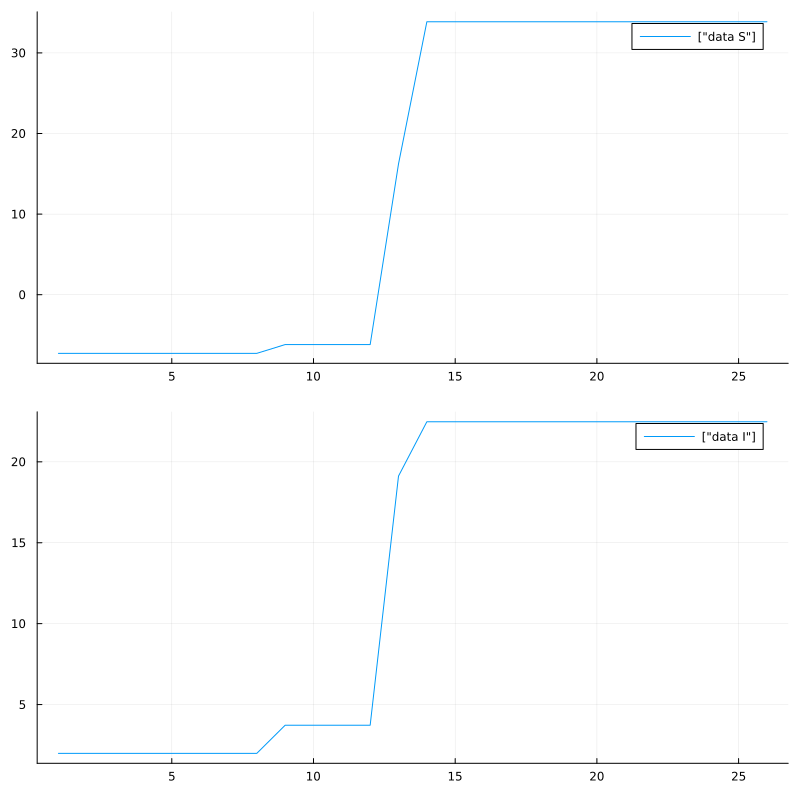

In [108]:
pS = plot(t, L[1,:], label=["data S"])
pI = plot(t, L[2,:], label=["data I"])


display(plot(pS, pI, layout = (2,1), size = (800, 800)))

In [109]:
problem = DirectDataDrivenProblem(X, L)

Direct DataDrivenProblem{Float64} ##DDProblem#535 in 3 dimensions and 26 samples

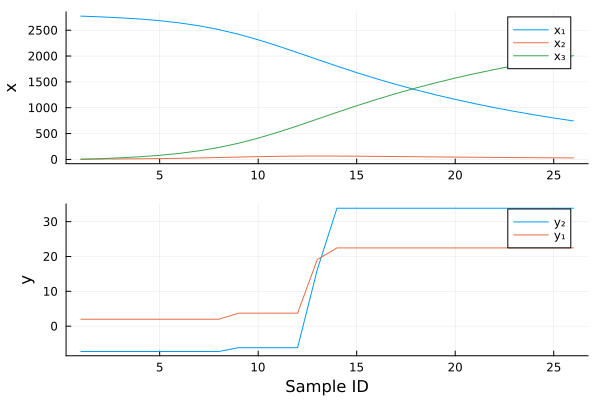

In [110]:
plot(problem)

In [111]:
@variables v
basis = Basis(monomial_basis([v],2), [v])

Model ##Basis#538 with 3 equations
States (1):
  v
Parameters (0):

In [ ]:
#h = Num[polynomial_basis(v, 3);]
# h = monomial_basis([u], 2)


In [112]:
sampler = DataSampler(Batcher(n = 5, shuffle = true, repeated = true))
λs = exp10.(-10:0.1:-1)
opt = STLSQ(λs)
res = solve(problem, basis, opt, progress = false, sampler = sampler, denoise = false, normalize = false, maxiter = 5000)
println(res)
println(result(res))

Linear Solution with 2 equations and 6 parameters.
Returncode: solved
L₂ Norm error : [1407.2346159614754, 301.08739962882754]
AIC : [200.48392659973527, 160.39241525723472]
R² : [0.8644160022774718, 0.880468073180141]

Model ##Basis#541 with 2 equations
States : v
Parameters : 6
Independent variable: t
Equations
φ₁ = p₁ + p₂*v + p₃*(v^2)
φ₂ = p₄ + p₅*v + p₆*(v^2)


In [ ]:
plot(plot(res))